#### [Required activity 25.3: Portfolio project on optimising a model for real-life data](https://classroom.emeritus.org/courses/3979/assignments/252208?module_item_id=1868475) - Predict images: Intel Image Classification<br>
<meta charset="ISO-8859-1">
<font color='orange'>Attention!</font> Make sure the "<font color='orange'>kaggle</font>" Python script text executable is installed and it is in the shell PATH!

In [1]:
!which kaggle

/usr/local/bin/kaggle


If the "kaggle" Python script text executable is not installed and it is not in the shell PATH!, there are two ways to solve this:<br>
1) Install it and make sure it is in the PATH always.<br>
or<br>
2) Use the Kaggle API and setup the private key in the kaggle.jason file.

In [2]:
!uname -a ; pwd ; df -khP . ; ls -lh ; pip install -q datasets ; pip install -q pyarrow ; pip install -q kaggle ; pip install -q torchinfo ; pip install -q  optuna

Linux 8d171959b14e 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
/content
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   37G   77G  33% /
total 4.0K
drwxr-xr-x 1 root root 4.0K Oct  1 16:12 sample_data
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [3]:
# import warnings
# warnings.filterwarnings('ignore')

In [4]:
import time, pytz, os, sys, json, zipfile, random#, kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi
from datetime import datetime
from pathlib import Path
# from memory_profiler import profile

In [5]:
import torch, optuna
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

### Rename SAVED_MODEL_FILENAME for training.
If you want <font color='orange'>to train the NN model</font>, it <font color='orange'>will take a long time</font>.<br>
If the previously trained and saved model file exists, trainng the model will be skipped.<br>
Find the actual filename below in the next cell.

In [6]:
global train_dataset
global test_dataset
global pred_dataset
global NN_MODEL_FULL           # filename to use when saving the PyTorch object of the NN trained model
NN_MODEL_FULL='checkpoint.pth' # filename to use when saving the PyTorch object of the NN trained model
global SAVED_MODEL_FILENAME    # constant that holds the filename where full model is saved
SAVED_MODEL_FILENAME='model_torch_state_dict' # full model is saved in this file

### Check for MPS (Apple Silicon), CUDA, fallback to CPU

We're checking for different device options (MPS, CUDA, or CPU) to ensure that the PyTorch model runs on the most powerful hardware available. Running on a GPU (like CUDA or MPS) significantly speeds up computations, especially for tasks involving large datasets or deep learning models, by performing parallel processing. If no GPU is available, the code falls back to using the CPU, which is slower but still functional.

MAC: newer Apple Silicon chips (M1/M2/M3) support GPU acceleration through Metal Performance Shaders (MPS) which is checked for optimising performance.

In [7]:
def device_hardware_gpu():
    device = torch.device(
        "mps"    if                              torch.backends.mps.is_available() else
        "cuda"   if                              torch.cuda.is_available() else
    #   "xpu"    if hasattr(torch, 'xpu') and    torch.xpu.is_available() else
    #   "ipu"    if hasattr(torch, 'ipu') and    torch.ipu.is_available() else
    #   "mkldnn" if                              torch.backends.mkldnn.is_available() else
    #   "opengl" if hasattr(torch, 'opengl') and torch.opengl.is_available() else
    #   "opencl" if hasattr(torch, 'opencl') and torch.opencl.is_available() else
    #   "ideep"  if hasattr(torch, 'ideep') and  torch.ideep.is_available() else
    #   "hip"    if hasattr(torch, 'hip') and    torch.hip.is_available() else
    #   "ve"     if hasattr(torch, 've') and     torch.ve.is_available() else
    #   "fpga"   if hasattr(torch, 'fpga') and   torch.fpga.is_available() else
    #   "ort"    if hasattr(torch, 'ort') and    torch.ort.is_available() else
    #   "xla"    if hasattr(torch, 'xla') and    torch.xla.is_available() else
    #   "lazy"   if hasattr(torch, 'lazy') and   torch.lazy.is_available() else
    #   "vulkan" if hasattr(torch, 'vulkan') and torch.vulkan.is_available() else
    #   "meta"   if hasattr(torch, 'meta') and   torch.meta.is_available() else
    #   "hpu"    if hasattr(torch, 'hpu') and    torch.hpu.is_available() else
    #   "mtia"   if hasattr(torch, 'mtia') and   torch.mtia.is_available() else
        "cpu")
    return device

    ''' colab.research.google.com

ERROR: Cannot connect to GPU backend    (Sat 28-Sep-2024 16:00 BST)
You cannot currently connect to a GPU due to usage limits in Colab. Learn more
To get more access to GPUs, consider purchasing Colab compute units with Pay.
   As You Go.
            [Close]         [Connect without GPU]

What is compute units in Google Colab?
Compute units (CU) are the units of measurement for the resources consumed by
Actor runs and builds. We charge you for using Actors based on CU consumption.
For example, if you run an Actor with 1GB of allocated memory for 1 hour, it
will consume 1 CU.
How many compute units are in a GPU?
A GPU Device is organized as a grid of Compute Units. Each Compute Unit is
organized as a grid of Processing Elements. So, in NVIDIA terms, their 4090 GPU
has 128 Compute Units, each of which has 128 Processing Elements, for a grand
total of 16,384 Processing Elements.15 Mar 2024
Can you get banned from Colab?
Google may, at its sole discretion, reduce usage limits to zero or effectively
ban Customer from using Paid Services or the Colab service in general.
    '''

'''
def setup_kaggle_credentials():

    home_dir = Path.home() # Get the user's home directory
    kaggle_dir = home_dir / '.kaggle'
    kaggle_json = kaggle_dir / 'kaggle.json'

    if not kaggle_dir.exists(): #exists? if not create it and set permissions
        kaggle_dir.mkdir(mode=0o700)
        print(f"Created directory: {kaggle_dir}")
    else:
        if os.stat(kaggle_dir).st_mode & 0o777 != 0o700:
            print(f"Setting permissions for existing directory: {kaggle_dir}")
            kaggle_dir.chmod(0o700) #os.chmod(kaggle_dir, 0o700)

    if not kaggle_json.exists(): #exists? if not create it with placeholder content
        placeholder_content = {
            "username": "user_id omitted for security purposes",
            "key":      "key     omitted for security purposes"
        }

        with kaggle_json.open('w') as f:
            json.dump(placeholder_content, f)

        kaggle_json.chmod(0o600)
        print(f"Created file: {kaggle_json}")

        print("\nPlease follow these instructions to set up your Kaggle API credentials:")
        print("(a) Browse to https://www.kaggle.com/settings")
        print("(b) Create New Token")
        print(f"(c) To use the API, save it locally as: {kaggle_json}")
    else:
        if os.stat(kaggle_json).st_mode & 0o777 != 0o600:
            print(f"Setting permissions for existing file: {kaggle_json}")
            kaggle_json.chmod(0o600) #os.chmod(kaggle_json, 0o600)

    print("\nKaggle credentials logic: passed.")
'''

### LOAD AND EXPLORE THE DATASET

In [8]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class IntelImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, unlabelled=False):
        """
        Args:
            root_dir (str): Root directory containing the images (and potentially subdirectories for classes).
            transform (callable, optional): Optional transform to be applied on a sample.
            unlabelled (bool): Flag to indicate whether the dataset is unlabelled (no subdirectories).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.unlabelled = unlabelled

        if self.unlabelled:
            # Load file list without labels for unlabelled data (no subdirectories)
            self.file_list = [os.path.join(root_dir, file) for file in os.listdir(root_dir) if file.endswith(('png', 'jpg', 'jpeg'))]
            self.class_list = None  # No class list since there are no labels
        else:
            # Load file list and class labels for labelled data (with subdirectories)
            self.classes = os.listdir(root_dir)
            self.file_list = []
            self.class_list = []
            for class_name in self.classes:
                class_path = os.path.join(root_dir, class_name)
                for file in os.listdir(class_path):
                    self.file_list.append(os.path.join(class_path, file))
                    self.class_list.append(self.classes.index(class_name))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.unlabelled: # Return only the image for unlabelled data
            return image
        else:               # Return both image and label for labelled data
            label = self.class_list[idx]
            return image, label

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

def check_directories_and_sizes():
    directories = {
        'seg_pred':  100 * 1024 * 1024, # 100 MB
        'seg_test':   40 * 1024 * 1024, #  40 MB
        'seg_train': 200 * 1024 * 1024  # 200 MB
    }

    for dir_name, min_size in directories.items():
        if not os.path.exists(dir_name) or get_directory_size(dir_name) < min_size:
            return False
    return True

def data_download_and_explore(): # https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
    dataset_name         = 'puneet6060/intel-image-classification'
    dataset_path         = '.' # intel-image-classification.zip is temporarily downloaded (346 MB) and deleted
    zip_filename = dataset_name.split("/")[1] + ".zip" # Extract the part after '/' and derive the expected zip file name
    extracted_path_train = 'seg_train/seg_train'
    extracted_path_test  =  'seg_test/seg_test'
    extracted_path_pred  =  'seg_pred/seg_pred'

    """# Check if the dataset is already downloaded and extracted
    if not check_directories_and_sizes():
        api = KaggleApi()
        api.authenticate() # Download the 400 MB dataset from Kaggle, in 3 subdirectories: seg_train seg_test seg_pred
        api.dataset_download_files(dataset_name, path=dataset_path, unzip=True) # download takes ~ 3 min
    else:
        print("\nDataset already downloaded and extracted. Skipping download.\n")"""

   # Check if the dataset is already downloaded and extracted
    if not check_directories_and_sizes():

        # DO NOT USE as this requires a private key in a file named kaggle.json
        # I DO NOT WANT TO SHARE MY PRIVATE KAGGLE KEY LEFT, RIGHT AND CENTER!
        #api = KaggleApi()
        #api.authenticate() # Download the 400 MB dataset from Kaggle, in 3 subdirectories: seg_train seg_test seg_pred
        #api.dataset_download_files(dataset_name, path=dataset_path, unzip=True) # download & extract takes ~ 2 mins

        # USE THIS as this is anonymous and does not require a private key
        # Download the dataset ZIP file archive. The "kaggle" Python script text executable must be in the shell PATH
        os.system(f"kaggle datasets download -d {dataset_name} -p {dataset_path}")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(dataset_path) # extract the contents (sub-dirs & files)
        os.remove(zip_filename) # Remove the dataset ZIP file archive
    else:
        print("\nDataset already downloaded and extracted. Skipping download.\n")

    # Create datasets, see `transform` above
    train_dataset = IntelImageDataset(root_dir=extracted_path_train, transform=transform, unlabelled=False) # Labelled data
    test_dataset  = IntelImageDataset(root_dir=extracted_path_test,  transform=transform, unlabelled=False) # Labelled data
    # For unlabelled data (e.g., prediction sub-dataset without sub-directories)
    pred_dataset = IntelImageDataset(root_dir=extracted_path_pred, transform=transform, unlabelled=True)  # Unlabelled data

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # labelled data
    test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False) # labelled data
    pred_loader = DataLoader(pred_dataset, batch_size=32, shuffle=False) # unlabelled data

    # Get all the labels (targets) from the dataset - start of bar chart plot
    labels = [label for _, label in train_dataset]
    # Count the occurrences of each label
    label_counts = Counter(labels)
    # Get the class names and the corresponding counts
    class_names = train_dataset.classes  # All class names
    counts = [label_counts[i] for i in range(len(class_names))]
    # Plot a bar chart
    plt.figure(figsize=(5, 3)) # plt.figure(figsize=(10, 6))
    plt.bar(class_names, counts)
    plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Class')
    plt.show()

    print(f'Number of batches per epoch: {len(train_loader)}')

    return train_dataset, test_dataset, pred_dataset, train_loader, test_loader, pred_loader, labels, class_names

def calculate_class_weights(labels, class_names): # Calculate class weights (inverse of class frequencies)
    label_counts = Counter(labels)
    class_counts = [label_counts[i] for i in range(len(class_names))]
    total_samples = sum(class_counts)
    class_weights = [total_samples / count for count in class_counts]

    print(f"\ncalculate_class_weights() :: class_weights:    {class_weights}\n")

    return total_samples, class_weights

def plot_images(images, labels, class_names): # Function to plot images
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(6):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Denormalise for display
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[labels[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_examples(train_dataset, test_dataset, class_names):
    examples = [] # Plot one example from each class
    labels = []
    for i in range(6):
        for image, label in train_dataset:
            if label == i:
                examples.append(image)
                labels.append(label)
                break

    plot_images(examples, labels, class_names) # Plot example images
    #summary(images, labels) # NO! summary() works on a model only
    #summary(examples, labels) # Print summary for train_dataset # NO! summary() works on a model only

    print("Dataset information:")
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of test samples: {len(test_dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"class_names: {class_names}")

def plot_random_examples(train_dataset, test_dataset, class_names, number_of_items=6):
    # Visualise a specified number of random images from the dataset and shows their labels.
    fig, axes = plt.subplots(1, number_of_items, figsize=(20, 10))

    indices = random.sample(range(len(train_dataset)), number_of_items)
    for i, idx in enumerate(indices):
        image, label = train_dataset[idx]

        image = image.numpy().transpose((1, 2, 0)) # Convert from tensor to numpy array and transpose

        # Denormalise the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean

        # Clip the values to be between 0 and 1
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].set_title(f"Label: {train_dataset.classes[label]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### Define the model architecture

In [9]:
'''
class AdaptiveLeNet5(nn.Module):
    # Very poor results for this model architecture based on LeNet5 - only 20% to 25%.
    # So, modify as below and add a layer.

    This is a derived class from LeNet5(nn.Module) with an adaptive input size.
    The original LeNet5 network architecture is modified to accept variable input
    sizes. This adaptive version uses nn.Sequential for the convolutional layers,
    allowing input images of various sizes. The fully connected layers are adjusted
    dynamically based on the input size.
    This AdaptiveLeNet5 class is designed to handle input images of varying sizes.
    * The convolutional layers are defined in a nn.Sequential container, allowing
        for automatic handling of different input sizes.
    * forward() method dynamically adjusts the first fully connected layer based on
        the actual size of the flattened feature map.
    * Use ReLU activation functions throughout and ends with a softmax
        activation for multi-class classification.
    * __str__() method is overridden to provide a clear string representation of
        the model architecture.
    This adaptive architecture allows the model to process images of different
    sizes without the need for manual resizing or padding, making it more flexible
    for datasets with varying image dimensions.

    def __init__(self):
        # Call the parent class constructor
        super(AdaptiveLeNet5, self).__init__()

        # Define the feature extraction layers
        self.features = nn.Sequential(
            # First convolutional layer: 3 input channels (RGB), 6 output channels, 5x5 kernel
            nn.Conv2d(3, 6, kernel_size=5),
            # ReLU activation function
            nn.ReLU(),
            # Max pooling layer with 2x2 kernel and stride of 2
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel
            nn.Conv2d(6, 16, kernel_size=5),
            # ReLU activation function
            nn.ReLU(),
            # Max pooling layer with 2x2 kernel and stride of 2
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the classifier layers
        self.classifier = nn.Sequential(
            # First fully connected layer: input size will be adjusted dynamically
            nn.Linear(16 * 5 * 5, 120),  # This will be adjusted in the forward pass
            # ReLU activation function
            nn.ReLU(),
            # Second fully connected layer: 120 input features, 84 output features
            nn.Linear(120, 84),
            # ReLU activation function
            nn.ReLU(),
            # Output layer: 84 input features, 6 output features (for 6 classes)
            nn.Linear(84, 6)
        )

    def forward(self, x):
        # Pass input through feature extraction layers
        x = self.features(x)

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)  # flatten all dimensions except batch

        # Dynamically adjust the first fully connected layer if necessary
        if x.shape[1] != 16 * 5 * 5:
            # Create a new Linear layer with the correct input size
            self.classifier[0] = nn.Linear(x.shape[1], 120)

        # Pass flattened features through the classifier layers
        x = self.classifier(x)

        # Apply softmax activation for multi-class classification
        return F.softmax(x, dim=1)

    def __str__(self):
        # Return a string representation of the model architecture
        return f"AdaptiveLeNet5:\n{super().__str__()}"
'''
'''
class EnhancedAdaptiveLeNet5(nn.Module):
    def __init__(self, num_classes=6):
        super(EnhancedAdaptiveLeNet5, self).__init__()

        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        # a Third convolutional layer addedd for better training performance
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Placeholder for fully connected layers
        # Initialize fc1 with a default input size; it will be adjusted dynamically in the forward pass
        self.fc1 = nn.Linear(128 * 28 * 28, 120)  # Default size based on input size (224x224 image)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the output from conv layers
        x = torch.flatten(x, 1)

        # Dynamically adjust the first fully connected layer based on input size
        if x.shape[1] != self.fc1.in_features:
            self.fc1 = nn.Linear(x.shape[1], 120).to(x.device)

        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def __str__(self):
        return f"EnhancedAdaptiveLeNet5:\n{super().__str__()}"
'''

class EnhancedAdaptiveLeNet5(nn.Module):
    def __init__(self, num_classes=6, dropout_rate=0.5):
        super(EnhancedAdaptiveLeNet5, self).__init__()

        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        # A third convolutional layer added for better training performance
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)

        # Pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Placeholder for fully connected layers
        # Initialise fc1 with a default input size; it will be adjusted dynamically in the forward pass
        self.fc1 = nn.Linear(128 * 28 * 28, 120)  # Default size based on input size (224x224 image)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten the output from conv layers
        x = torch.flatten(x, 1)

        # Dynamically adjust the first fully connected layer based on input size
        if x.shape[1] != self.fc1.in_features:
            self.fc1 = nn.Linear(x.shape[1], 120).to(x.device)

        # Pass through fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

    def __str__(self):
        return f"EnhancedAdaptiveLeNet5:\n{super().__str__()}"

def objective(trial, train_loader, test_loader, device): # Hyperparameter suggestions
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    l1_lambda = trial.suggest_float('l1_lambda', 1e-5, 1e-3, log=True)
    l2_lambda = trial.suggest_float('l2_lambda', 1e-5, 1e-3, log=True)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    model = EnhancedAdaptiveLeNet5(num_classes=6, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)
    criterion = nn.CrossEntropyLoss()

    # Training loop for the objective function
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:  # Use the global train_loader
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Add L1 regularization
            l1_penalty = 0
            for param in model.parameters():
                l1_penalty += torch.norm(param, 1)
            loss += l1_lambda * l1_penalty

            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:  # Use the global test_loader
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy # we want to maximise accuracy

'''
def instantiate_cnn(device, class_weights):
    enhancedadaptivelenet5 = EnhancedAdaptiveLeNet5().to(device) # adaptivelenet5 = AdaptiveLeNet5().to(device)
    # Convert class_weights to a tensor and move to the device
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use CrossEntropyLoss with weights
    # Optimizer (SGD or Adam is used)
    # optimizer = optim.SGD(adaptivelenet5.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(enhancedadaptivelenet5.parameters(), lr=0.001) # optimizer = optim.Adam(adaptivelenet5.parameters(), lr=0.001)
    return enhancedadaptivelenet5, criterion, optimizer # return adaptivelenet5, criterion, optimizer
'''

def instantiate_cnn(device, class_weights):
    enhancedadaptivelenet5 = EnhancedAdaptiveLeNet5(dropout_rate=0.4704573106718749).to(device) # adaptivelenet5 = AdaptiveLeNet5().to(device)
    # Convert class_weights to a tensor and move to the device
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # Use CrossEntropyLoss with weights
    # Optimizer (SGD or Adam is used)
    # optimizer = optim.SGD(adaptivelenet5.parameters(), lr=0.001, momentum=0.9)
    '''
[I 2024-10-02 12:05:58,995] Trial 1 finished with value: 0.33003300330033003 and parameters:
{'dropout_rate': 0.4704573106718749, 'l1_lambda': 7.007654740303945e-05, 'l2_lambda': 2.4830288808308213e-05, 'lr': 0.0009161427670616852}. Best is trial 1 with value: 0.33003300330033003
    '''
    optimizer = optim.Adam(enhancedadaptivelenet5.parameters(), lr=0.0009161427670616852, weight_decay=0.00002483028880830821) # optimizer = optim.Adam(adaptivelenet5.parameters(), lr=0.001)
    return enhancedadaptivelenet5, criterion, optimizer # return adaptivelenet5, criterion, optimizer

### Train the Convolutional Neural Network Model

In [10]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=100, early_stop_patience=4, checkpoint_path='checkpoint.pth'):
    """
    Train the given model on the provided data using the specified criterion and optimizer.
    This is part of: training, evaluating/validating, testing

    Args:
        model: The neural network model to train.
        train_loader: DataLoader for the training dataset.
        criterion: Loss function to optimize.
        optimizer: Optimization algorithm for updating model parameters.
        device: Device to use for training (CPU or GPU).
        num_epochs: Maximum number of training epochs.
        early_stop_patience: Number of epochs without improvement to trigger early stopping.
        checkpoint_path: Path to save model checkpoints.
    """
    now = datetime.now() # get the time now
    timezone = now.astimezone().tzname() # Get the timezone name
    print("\nTime now: " + now.strftime("%A, %B %d, %Y %H:%M:%S ") + timezone + "\033[1m\033[38;5;208m\n\nStarting to train model\033[0m with " + str(num_epochs) + " EPOCHs. (or with " + str(num_epochs) + " repeated loops through the full dataset)...\n")
    """
    https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

    Epoch
    An epoch describes the number of times the algorithm sees the entire data set.
    So, each time the algorithm has seen all samples in the dataset, an epoch has been completed.

    Iteration
    An iteration describes the number of times a batch of data passed through the algorithm.
    In the case of neural networks, that means the forward pass and backward pass.
    So, every time you pass a batch of data through the NN, you completed an iteration.

    Example
    An example might make it clearer.

    Say you have a dataset of 10 examples (or samples). You have a batch size of 2
    and you've specified you want the algorithm to run for 3 epochs.

    Therefore, in each epoch, you have 5 batches (10/2 = 5). Each batch gets passed through
    the algorithm, therefore you have 5 iterations per epoch. Since you've specified 3 epochs,
    you have a total of 15 iterations (5*3 = 15) for training.
    """

    best_val_loss = float('inf')
    early_stop_counter = 0

    # Load checkpoint if it exists
    start_epoch = 0
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)  # Load on the specified device
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch}")
    except FileNotFoundError:
        print("No checkpoint found, starting from scratch.")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(train_loader),
        }
        torch.save(checkpoint, checkpoint_path)

        # Validation step - on the validation train_loader
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation for evaluation
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(test_loader) # Average validation loss

        # Print training loss
        #print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.6f}')
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {running_loss / len(train_loader):.6f}, Validation Loss: {val_loss:.6f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print('Early stopping due to no improvement in validation loss.')
            break

    try: # Save the trained model
        torch.save(model.state_dict(), SAVED_MODEL_FILENAME)
        print(f"Saved the trained model in file: {SAVED_MODEL_FILENAME}\n")
        print("\033[1m\033[38;5;208mA WHOLE MODELis now available in the file above after neural network has been trained\033[0m.")
    except Exception as e: # Print error code and message on failure
        print(f"\033[1m\033[38;5;196m*** ERROR ***\033[0m while saving the trained model in file: {SAVED_MODEL_FILENAME}:\n    {type(e).__name__}: {e}")

    print("\n\033[1m\033[38;5;208mFinished Training the model\033[0m\n")
    now = datetime.now() # get the time now
    timezone = now.astimezone().tzname() # Get the timezone name
    print("Time now: " + now.strftime("%A, %B %d, %Y %H:%M:%S ") + timezone)

"""
def load_saved_model_from_file(num_classes):
    # Load the saved model from file on disk
    model = EnhancedAdaptiveLeNet5(num_classes=num_classes)
    model.load_state_dict(torch.load(SAVED_MODEL_FILENAME))

    return model
"""

def load_saved_model_from_file(num_classes, device):
    # Load the saved model and move it to the specified device
    model = EnhancedAdaptiveLeNet5(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load(SAVED_MODEL_FILENAME, map_location=device)) # Load state dict to the correct device
    return model

def evaluate_model(model, data_loader, device, class_names, data_loader_name):
    """
    Evaluate the model on the dataset provided and print performance metrics.

    Args:
        model: The neural network model to evaluate
        data_loader: DataLoader for the dataset on which the evaluation'll run
        device: Device to use for evaluation (mps GPU, or cuda GPU or cpu)
        class_names: List of class names for the dataset
        data_loader_name: human readable string, showing which piece of the data we are on
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in data_loader:
            images = images.to(device)  # Move images to the same device as the model
            labels = labels.to(device)  # Move labels to the same device as the model

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability

            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())  # Move predictions to CPU for evaluation
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU for evaluation

    # Compute performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    # Print performance
    print(f'\nAccuracy: {accuracy * 100:.2f}% for dataset: {data_loader_name}')
    print(f'Balanced Accuracy: {balanced_acc * 100:.2f}%')
    print(f'Macro F1 Score: {f1:.4f}')

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {data_loader_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [11]:
def predict_image_class(model, data_loader, device, class_names, num_images=10):
    """
    Predict the class for a random set of unlabelled images and display them with the predicted labels.

    Args:
        model: The trained neural network model
        data_loader: DataLoader containing unlabelled images
        device: Device to use for prediction (mps GPU, cuda GPU, or cpu)
        class_names: List of class names for the dataset
        num_images: Number of random images to predict (default 10)
    """
    model.eval()  # Set model to evaluation mode

    # Collect all images from the DataLoader
    all_images = []
    for images in data_loader:
        all_images.append(images)

    # Flatten the list of batches into a single list of images
    all_images = torch.cat(all_images, dim=0)

    # Randomly sample num_images from all_images
    sampled_indices = random.sample(range(len(all_images)), num_images)
    sampled_images = all_images[sampled_indices]

    with torch.no_grad():  # Disable gradient calculation for prediction
        # Move sampled images to the same device as the model
        sampled_images = sampled_images.to(device)

        # Forward pass to get model predictions
        outputs = model(sampled_images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability

        # Create subplots for the images in a single row
        fig, axes = plt.subplots(1, num_images, figsize=(20, 5))  # 1 row, num_images columns

        for i, image in enumerate(sampled_images.cpu()):
            axes[i].imshow(image.permute(1, 2, 0))  # Convert from tensor to image format (HWC)
            axes[i].set_title(f'Predicted: {class_names[predicted[i].item()]}')
            axes[i].axis('off')  # Hide the axes

        plt.tight_layout()
        plt.show()

## MAIN() construct for executing at run-time

Time now: Wednesday, October 02, 2024 17:41:06 UTC
Using cuda device

  *** LOAD AND EXPLORE THE DATASET



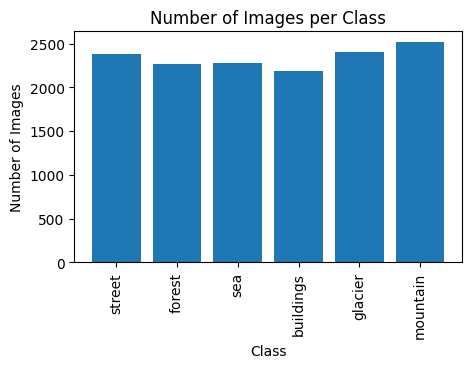

Number of batches per epoch: 439

  *** PLOT EXAMPLES OF THE DATASET



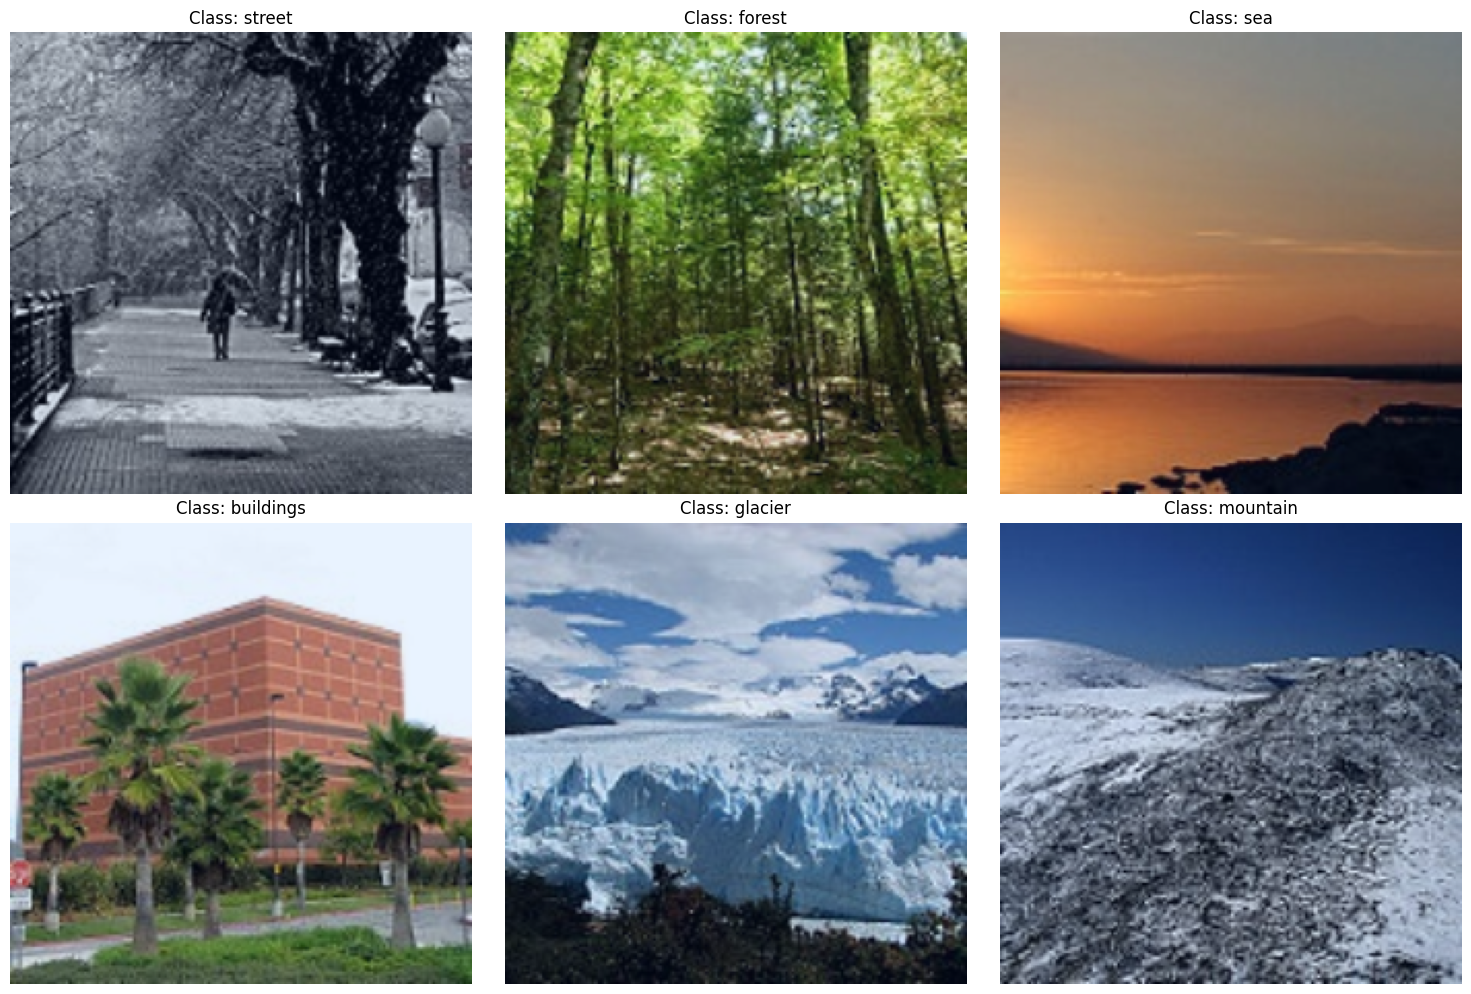

Dataset information:
Number of training samples: 14034
Number of test samples: 3000
Number of classes: 6
class_names: ['street', 'forest', 'sea', 'buildings', 'glacier', 'mountain']


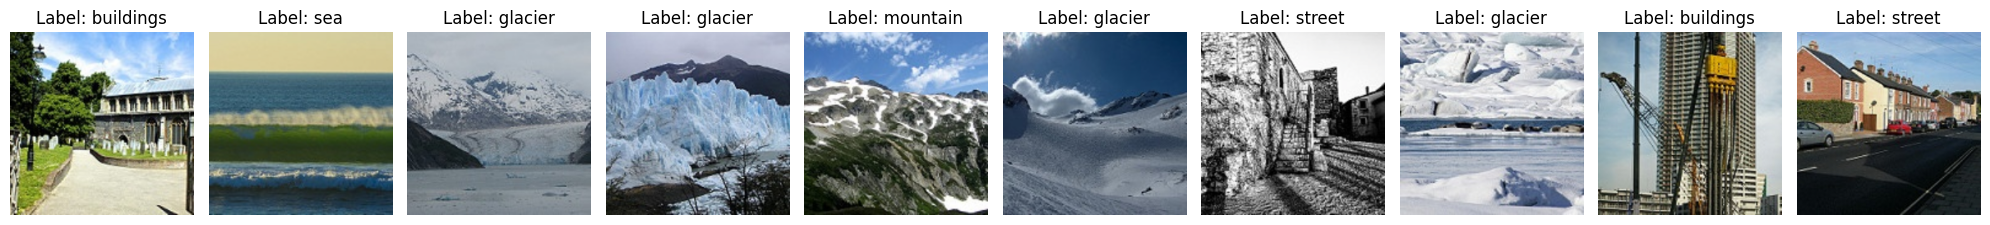


calculate_class_weights() :: class_weights:    [5.89168765743073, 6.179656538969617, 6.171503957783641, 6.405294386125057, 5.837770382695507, 5.586783439490445]

main() ::                    class_weights:    [5.89168765743073, 6.179656538969617, 6.171503957783641, 6.405294386125057, 5.837770382695507, 5.586783439490445]



[I 2024-10-02 17:42:56,368] A new study created in memory with name: no-name-d1943ddc-3ec6-4420-afae-663406bfe3ec


Time now: Wednesday, October 02, 2024 17:42:56 UTC
main() :: Hyperparameter tuning: study.optimize(n_trials=20)



[I 2024-10-02 17:47:50,168] Trial 0 finished with value: 0.767 and parameters: {'dropout_rate': 0.419457726500749, 'l1_lambda': 3.337822727575922e-05, 'l2_lambda': 0.00010645799009359794, 'lr': 0.005228104759146851}. Best is trial 0 with value: 0.767.
[I 2024-10-02 17:52:45,215] Trial 1 finished with value: 0.6433333333333333 and parameters: {'dropout_rate': 0.4843204149936132, 'l1_lambda': 1.982037281728854e-05, 'l2_lambda': 0.0003018489547951061, 'lr': 0.005148887957838702}. Best is trial 0 with value: 0.767.
[I 2024-10-02 17:57:38,731] Trial 2 finished with value: 0.842 and parameters: {'dropout_rate': 0.2944387482706391, 'l1_lambda': 5.3968081879277036e-05, 'l2_lambda': 0.0006059209913759136, 'lr': 0.00016411111051776713}. Best is trial 2 with value: 0.842.
[I 2024-10-02 18:02:31,599] Trial 3 finished with value: 0.7953333333333333 and parameters: {'dropout_rate': 0.39929120995883793, 'l1_lambda': 1.5733878816728838e-05, 'l2_lambda': 0.00014470141761622308, 'lr': 0.0004864252692380

main() :: os.path.exists(SAVED_MODEL_FILENAME):False


Time now: Wednesday, October 02, 2024 19:20:57 UTC

Starting to train model with 45 EPOCHs. (or with 45 repeated loops through the full dataset)...

No checkpoint found, starting from scratch.
Epoch [1/45], Training Loss: 1.178353, Validation Loss: 3.883324
Epoch [2/45], Training Loss: 0.866284, Validation Loss: 2.858929
Epoch [3/45], Training Loss: 0.748342, Validation Loss: 2.605726
Epoch [4/45], Training Loss: 0.673894, Validation Loss: 2.465532
Epoch [5/45], Training Loss: 0.619341, Validation Loss: 2.116992
Epoch [6/45], Training Loss: 0.576473, Validation Loss: 1.849844
Epoch [7/45], Training Loss: 0.546045, Validation Loss: 2.050783
Epoch [8/45], Training Loss: 0.512505, Validation Loss: 1.589270
Epoch [9/45], Training Loss: 0.489516, Validation Loss: 1.682565
Epoch [10/45], Training Loss: 0.451410, Validation Loss: 1.491413
Epoch [11/45], Training Loss: 0.432454, Validation Loss: 1.443966
Epoch [12/45], Training Loss: 0.402

<ipython-input-10-b47df5aa8c0a>:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(SAVED_MODEL_FILENAME, map_location=device)) # Load state 


Accuracy: 98.77% for dataset: train_loader
Balanced Accuracy: 98.78%
Macro F1 Score: 0.9878


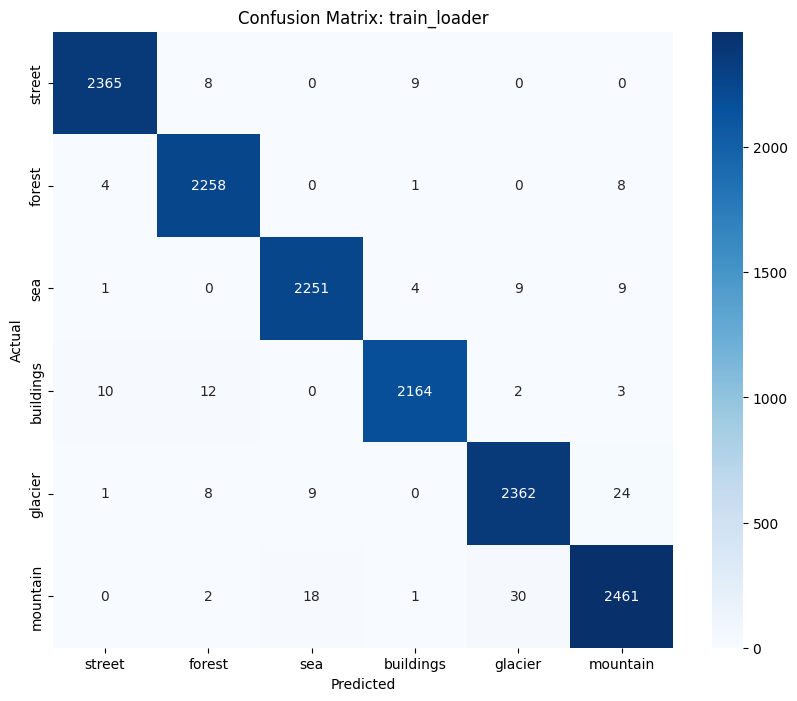


Accuracy: 84.57% for dataset: test_loader
Balanced Accuracy: 84.58%
Macro F1 Score: 0.8464


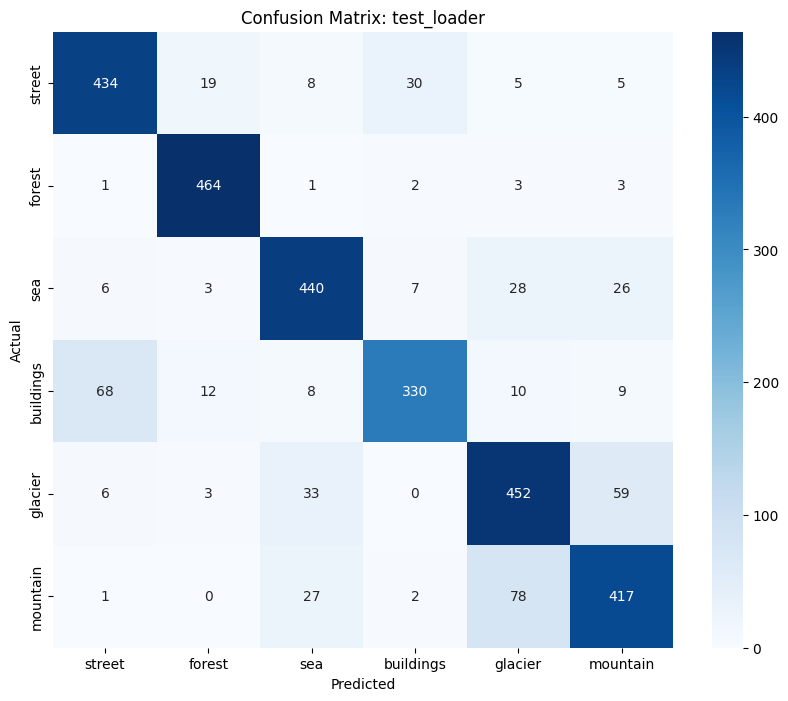

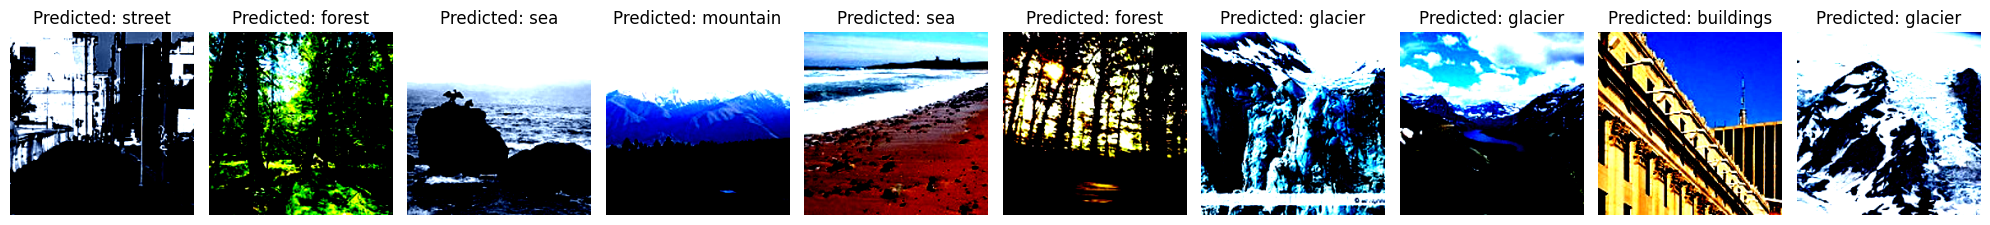


*** FINISED ***
Time now: Wednesday, October 02, 2024 20:10:04 UTC
Elapsed Time: 148 minute(s) 57 second(s)



In [12]:
def main():
    #print("Python version:", sys.version)
    global train_dataset
    global test_dataset
    global pred_dataset
    global NN_MODEL_FULL

    start_time = time.time()    # Record the start time
    now =        datetime.now() # ditto
    #tz_London = pytz.timezone('Europe/London') # Get the timezone object for London
    #datetime_London = datetime.now(tz_London) # Get the current time in London
    #print("\nStarting... Time now:", datetime_London.strftime("%A, %B %d, %Y %H:%M:%S"), "\n") # Format the time as a string and print it
    print("Time now: " + now.strftime("%A, %B %d, %Y %H:%M:%S ") + datetime.now().astimezone().tzname()) # Format the time as a string and print it

    device = device_hardware_gpu() #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using \033[1m\033[38;5;208m{device}\033[0m device")
    #setup_kaggle_credentials() # needed, to be able to download the dataset from Kaggle

    # MAIN FUNCTIONALITY START
    print("\n  *** \033[1m\033[38;5;208mLOAD AND EXPLORE\033[0m THE DATASET\n")
    train_dataset, test_dataset, pred_dataset, train_loader, test_loader, pred_loader, labels, class_names = data_download_and_explore()
    print("\n  *** \033[1m\033[38;5;208mPLOT EXAMPLES\033[0m OF THE DATASET\n")
    plot_examples(train_dataset, test_dataset, class_names)
    plot_random_examples(train_dataset, test_dataset, class_names, 10)
    total_samples, class_weights = calculate_class_weights(labels, class_names) # Calculate class weights (inverse of class frequencies)
    print(f"main() ::                    class_weights:    {class_weights}\n")
    enhancedadaptivelenet5, criterion, optimizer = instantiate_cnn(device, class_weights) # adaptivelenet5, criterion, optimizer = instantiate_cnn(device, class_weights)

    # Optuna study (auto hyperparameter tuning)
    study = optuna.create_study(direction='maximize') #want to maximise accuracy
    now = datetime.now()
    print("Time now: " + now.strftime("%A, %B %d, %Y %H:%M:%S ") + datetime.now().astimezone().tzname()) # Format the time as a string and print it
    print(f"main() :: Hyperparameter tuning: study.optimize(n_trials=20)\n")
    #study.optimize(objective, n_trials=20)
    study.optimize(lambda trial: objective(trial, train_loader, test_loader, device=device), n_trials=20)

    # Main training with best hyperparameters
    best_params = study.best_params
    best_model = EnhancedAdaptiveLeNet5(num_classes=6, dropout_rate=best_params['dropout_rate']).to(device)
    best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'], weight_decay=best_params['l2_lambda'])

    #print(f"\nNN_MODEL_FULL file name: {NN_MODEL_FULL}")
    print(f"main() :: os.path.exists(SAVED_MODEL_FILENAME):{os.path.exists(SAVED_MODEL_FILENAME)}\n")
    if not os.path.exists(SAVED_MODEL_FILENAME):
        #train_model(enhancedadaptivelenet5, train_loader, test_loader, criterion, optimizer, device, num_epochs=45, checkpoint_path=NN_MODEL_FULL) # train_model(adaptivelenet5, train_loader, criterion, optimizer, device, 15)
        train_model(best_model, train_loader, test_loader, criterion, best_optimizer, device, num_epochs=45, checkpoint_path=NN_MODEL_FULL)
    model = load_saved_model_from_file(len(class_names), device) # Load model onto the correct device, returns model
    # Evaluate on the training dataset (Accuracy & Confusion Matrix)
    evaluate_model(model, train_loader, device, class_names, "train_loader") # evaluate_model(adaptivelenet5, train_loader, device, class_names)
    evaluate_model(model, test_loader,  device, class_names, "test_loader") # Evaluate on the test dataset for validation purposes (Accuracy & Confusion Matrix)
    predict_image_class(model, pred_loader, device, class_names, num_images=10)
    # MAIN FUNCTIONALITY END

    #datetime_London = datetime.now(tz_London) # Get the current time in London
    now = datetime.now() #print("\nTime now:", datetime_London.strftime("%A, %B %d, %Y %H:%M:%S")) # Format the time as a string and print it
    timezone = now.astimezone().tzname() # Get the timezone name
    print("\n***\033[1m\033[38;5;208m FINISED\033[0m ***")
    print("Time now: " + now.strftime("%A, %B %d, %Y %H:%M:%S ") + timezone) # Format the time as a string and print it
    elapsed_time = time.time() - start_time # Calculate and print the elapsed time
    print(f"Elapsed Time: {int(elapsed_time // 60)} minute(s) {int(elapsed_time % 60)} second(s)\n")

    return train_dataset

if __name__ == '__main__':
    main()

In [13]:
type(train_dataset)

__main__.IntelImageDataset

print("vars(train_dataset)\n") # OR print("train_dataset.__dict__\n")
print(vars(train_dataset))     # OR print(train_dataset.__dict__) # 'root_dir', 'transform', 'classes', 'file_list', 'class_list'

These attributes or variables in the dictionary, together define the structure of the dataset:

 * root_dir tells where to find the images.
 * transform defines how to preprocess the images.
 * classes provides the class names.
 * file_list and class_list together provide the path to each image and its corresponding class as an integer.

In [14]:
len(train_dataset)
# summary(model, input_size=(1, 3, 32, 32)) # Print summary

14034

In [15]:
len(test_dataset)

3000

In [16]:
'''
def estimate_memory_usage(dataset):
    memory = 0
    memory += sys.getsizeof(dataset.root_dir)
    memory += sys.getsizeof(dataset.transform)
    memory += sys.getsizeof(dataset.classes)
    memory += sum(sys.getsizeof(file) for file in dataset.file_list)
    memory += sys.getsizeof(dataset.class_list)
    return memory
'''

def estimate_memory_usage(obj):
    memory = sys.getsizeof(obj)  # Start with the size of the object itself

    if hasattr(obj, '__dict__'):
        for attr_name, attr_value in obj.__dict__.items():
            print(attr_name)
            if isinstance(attr_value, (str, list, dict, set, tuple)):
                memory += sys.getsizeof(attr_value)

                # For containers, add size of each element
                if isinstance(attr_value, (list, set, tuple)):
                    memory += sum(sys.getsizeof(item) for item in attr_value)
                elif isinstance(attr_value, dict):
                    memory += sum(sys.getsizeof(key) + sys.getsizeof(value) for key, value in attr_value.items())
            else:
                # For other types, just add their size
                memory += sys.getsizeof(attr_value)

    return memory

memory_usage = estimate_memory_usage(train_dataset)
print(f"Estimated memory usage: {memory_usage / 1024 / 1024:.2f} MB")

root_dir
transform
unlabelled
classes
file_list
class_list
Estimated memory usage: 1.73 MB


# Understanding:

The estimated memory usage of approximately 1 or 2 MB represents only the metadata and structural information of the dataset, not the actual image data.
This memory usage includes things like:
 * The file paths stored in file_list
 * The class names in classes
 * The class indices in class_list
 * Other small attributes like root_dir and transform
The actual image data is not loaded into memory. Your dataset is likely using lazy loading, which means:
Images are only loaded when accessed (e.g., when you train dataset is called)
After use, the image data is typically released from memory

The IntelImageDataset class is probably designed to be memory-efficient by:
 * Storing only file paths and labels
 * Loading images on-demand
 * Applying transformations at runtime rather than storing transformed images

This approach allows for work with large datasets that wouldn't fit entirely in memory. The trade-off is that accessing data might be slower (due to disk I/O) compared to having everything pre-loaded in RAM.

So, there are no graphical images stored in memory as part of this dataset object. The images will only be loaded into memory when they are needed actually for access, typically during training or evaluation loops of the model.

Required activity 25.3: Portfolio project on optimising a model for real-life data¶

```Shell
# !pip install -q datasets
!pip install datasets
Collecting datasets
  Downloading datasets-3.0.0-py3-none-any.whl.metadata (19 kB)
Requirement already satisfied: filelock in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from datasets) (3.13.1)
Requirement already satisfied: numpy>=1.17 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from datasets) (1.24.0)
Collecting pyarrow>=15.0.0 (from datasets)
  Downloading pyarrow-17.0.0-cp311-cp311-macosx_10_15_x86_64.whl.metadata (3.3 kB)
Requirement already satisfied: dill<0.3.9,>=0.3.0 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from datasets) (0.3.7)
Requirement already satisfied: pandas in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from datasets) (2.2.2)
Collecting requests>=2.32.2 (from datasets)
  Downloading requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Collecting tqdm>=4.66.3 (from datasets)
  Downloading tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.4 MB/s eta 0:00:00
Collecting xxhash (from datasets)
  Downloading xxhash-3.5.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata (12 kB)
Collecting multiprocess (from datasets)
  Downloading multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
Requirement already satisfied: fsspec<=2024.6.1,>=2023.1.0 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from fsspec[http]<=2024.6.1,>=2023.1.0->datasets) (2023.10.0)
Requirement already satisfied: aiohttp in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from datasets) (3.9.3)
Collecting huggingface-hub>=0.22.0 (from datasets)
  Downloading huggingface_hub-0.25.0-py3-none-any.whl.metadata (13 kB)
Requirement already satisfied: packaging in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from datasets) (24.1)
Requirement already satisfied: pyyaml>=5.1 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from datasets) (6.0.2)
Requirement already satisfied: aiosignal>=1.1.2 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from aiohttp->datasets) (1.2.0)
Requirement already satisfied: attrs>=17.3.0 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from aiohttp->datasets) (23.1.0)
Requirement already satisfied: frozenlist>=1.1.1 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from aiohttp->datasets) (1.4.0)
Requirement already satisfied: multidict<7.0,>=4.5 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from aiohttp->datasets) (6.0.4)
Requirement already satisfied: yarl<2.0,>=1.0 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from aiohttp->datasets) (1.9.3)
Requirement already satisfied: typing-extensions>=3.7.4.3 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from huggingface-hub>=0.22.0->datasets) (4.9.0)
Requirement already satisfied: charset-normalizer<4,>=2 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from requests>=2.32.2->datasets) (2.0.4)
Requirement already satisfied: idna<4,>=2.5 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from requests>=2.32.2->datasets) (3.4)
Requirement already satisfied: urllib3<3,>=1.21.1 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from requests>=2.32.2->datasets) (1.26.18)
Requirement already satisfied: certifi>=2017.4.17 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from requests>=2.32.2->datasets) (2024.8.30)
Collecting dill<0.3.9,>=0.3.0 (from datasets)
  Downloading dill-0.3.8-py3-none-any.whl.metadata (10 kB)
Requirement already satisfied: python-dateutil>=2.8.2 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from pandas->datasets) (2.8.2)
Requirement already satisfied: pytz>=2020.1 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from pandas->datasets) (2023.3.post1)
Requirement already satisfied: tzdata>=2022.7 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from pandas->datasets) (2023.3)
Requirement already satisfied: six>=1.5 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from python-dateutil>=2.8.2->pandas->datasets) (1.16.0)
Downloading datasets-3.0.0-py3-none-any.whl (474 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 3.6 MB/s eta 0:00:0000:0100:01
Downloading huggingface_hub-0.25.0-py3-none-any.whl (436 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 3.4 MB/s eta 0:00:0000:0100:01
Downloading pyarrow-17.0.0-cp311-cp311-macosx_10_15_x86_64.whl (29.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 4.5 MB/s eta 0:00:0000:0100:01
Downloading requests-2.32.3-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.1 MB/s eta 0:00:00ta 0:00:01
Downloading tqdm-4.66.5-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
Downloading multiprocess-0.70.16-py311-none-any.whl (143 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.1 MB/s eta 0:00:0000:01
Downloading dill-0.3.8-py3-none-any.whl (116 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.2 MB/s eta 0:00:00a 0:00:01
Downloading xxhash-3.5.0-cp311-cp311-macosx_10_9_x86_64.whl (31 kB)
Installing collected packages: xxhash, tqdm, requests, pyarrow, dill, multiprocess, huggingface-hub, datasets
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7
```

<meta charset="ISO-8859-1">
<code style="background:yellow;color:black"> **** ERROR: **** </code>

```Shell
pip.s dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
streamlit 1.30.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatible.
aima3 1.0.11 requires networkx==1.11, but you have networkx 3.3 which is incompatible.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires PyYAML==6.0.1, but you have pyyaml 6.0.2 which is incompatible.
conda-repo-cli 1.0.75 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
Successfully installed datasets-3.0.0 dill-0.3.8 huggingface-hub-0.25.0 multiprocess-0.70.16 pyarrow-17.0.0 requests-2.32.3 tqdm-4.66.5 xxhash-3.5.0



 pip install kaggle
Collecting kaggle
  Downloading kaggle-1.6.17.tar.gz (82 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 485.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Requirement already satisfied: six>=1.10 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from kaggle) (1.16.0)
Requirement already satisfied: certifi>=2023.7.22 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from kaggle) (2024.8.30)
Requirement already satisfied: python-dateutil in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from kaggle) (2.8.2)
Requirement already satisfied: requests in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from kaggle) (2.32.3)
Requirement already satisfied: tqdm in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from kaggle) (4.66.5)
Requirement already satisfied: python-slugify in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from kaggle) (5.0.2)
Requirement already satisfied: urllib3 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from kaggle) (1.26.18)
Requirement already satisfied: bleach in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from kaggle) (4.1.0)
Requirement already satisfied: packaging in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from bleach->kaggle) (24.1)
Requirement already satisfied: webencodings in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from bleach->kaggle) (0.5.1)
Requirement already satisfied: text-unidecode>=1.3 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from python-slugify->kaggle) (1.3)
Requirement already satisfied: charset-normalizer<4,>=2 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from requests->kaggle) (2.0.4)
Requirement already satisfied: idna<4,>=2.5 in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from requests->kaggle) (3.4)
Building wheels for collected packages: kaggle
  Building wheel for kaggle (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=ec0f6b15843986ed83ee576c9749f572e9adaae4e4c04c5b1c14d83ea552012a
  Stored in directory: /Users/dian/Library/Caches/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
Installing collected packages: kaggle
Successfully installed kaggle-1.6.17
# Saturday 21 September 2024 14:58 BST


 pip install memory_profiler
Collecting memory_profiler
  Downloading memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
Requirement already satisfied: psutil in /Users/dian/Applications/anaconda3/lib/python3.11/site-packages (from memory_profiler) (5.9.0)
Downloading memory_profiler-0.61.0-py3-none-any.whl (31 kB)
Installing collected packages: memory_profiler
Successfully installed memory_profiler-0.61.0
# Saturday 21 September 2024 15:47 BST


 pip install torchinfo
Collecting torchinfo
  Downloading torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Downloading torchinfo-1.8.0-py3-none-any.whl (23 kB)
Installing collected packages: torchinfo
Successfully installed torchinfo-1.8.0
# Monday 23 September 2024 11:04 BST
```

In [17]:
![[ -d "$HOME/.config/kaggle" ]] && cat /etc/os-release | egrep -i "_name|like" ; df -khPa ~ ; echo $HOME ; whoami ; id ; [[ -d "$HOME/.config" ]] && \ls -la $HOME/.config ; [[ -d "$HOME/.kaggle" ]] && \ls -la $HOME/.kaggle

PRETTY_NAME="Ubuntu 22.04.3 LTS"
ID_LIKE=debian
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   38G   76G  33% /
/root
root
uid=0(root) gid=0(root) groups=0(root)
total 20
drwxr-xr-x 1 root root 4096 Oct  2 17:41 .
drwx------ 1 root root 4096 Oct  2 17:41 ..
drwxr-xr-x 2 root root 4096 Oct  2 17:41 kaggle
drwxr-xr-x 2 root root 4096 Oct  1 16:34 matplotlib


In [18]:
![ -d "$HOME/.config/kaggle" ] &&             ls -lh $HOME/.config/kaggle # if running on http://colab.google.com
![ -f "$HOME/.config/kaggle/kaggle.json" ] && cat    $HOME/.config/kaggle/kaggle.json # if running on http://colab.google.com

total 0


In [19]:
'''
import os, zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

def check_directories_and_sizes():
    directories = {
        'seg_pred':  100 * 1024 * 1024, # 100 MB
        'seg_test':   40 * 1024 * 1024, #  40 MB
        'seg_train': 200 * 1024 * 1024  # 200 MB
    }

    for dir_name, min_size in directories.items():
        if not os.path.exists(dir_name) or get_directory_size(dir_name) < min_size:
            return False
    return True
'''
'''
def data_download_and_explore():
    dataset_name         = 'puneet6060/intel-image-classification'
    dataset_path         = '.' # intel-image-classification.zip is temporarily downloaded (346 MB) and deleted
    #zip_filename = dataset_name.replace("/", "-") + ".zip"  # Construct the expected zip file name
    zip_filename = dataset_name.split("/")[1] + ".zip" # Extract the part after '/' and derive the expected zip file name
    extracted_path_train = 'seg_train/seg_train'
    extracted_path_test  =  'seg_test/seg_test'
    extracted_path_pred  =  'seg_pred/seg_pred'

    # Check if the dataset is already downloaded and extracted
    if not check_directories_and_sizes():

        # DO NOT USE as this requires a private key in a file named kaggle.json
        # I DO NOT WANT TO SHARE MY PRIVATE KAGGLE KEY LEFT, RIGHT AND CENTER!
        #api = KaggleApi()
        #api.authenticate() # Download the 400 MB dataset from Kaggle, in 3 subdirectories: seg_train seg_test seg_pred
        #api.dataset_download_files(dataset_name, path=dataset_path, unzip=True) # download & extract takes ~ 2 mins

        # USE THIS as this is anonymous and does not require a private key
        # Download the dataset ZIP file archive. The "kaggle" Python script text executable must be in the shell PATH
        os.system(f"kaggle datasets download -d {dataset_name} -p {dataset_path}")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(dataset_path) # extract the contents (sub-dirs & files)
        os.remove(zip_filename) # Remove the dataset ZIP file archive
    else:
        print("\nDataset already downloaded and extracted. Skipping download.\n")

data_download_and_explore()
'''
time.sleep(1)

In [20]:
#![ ! -d "$HOME/.config/kaggle" ] && mkdir -p $HOME/.config/kaggle # if running on http://colab.google.com
#![   -d "$HOME/.config/kaggle" ] && ls -lh   $HOME/.config/kaggle # if running on http://colab.google.com

In [21]:
# %%writefile $HOME/.config/kaggle/kaggle.json
#{"username":"dianivanov","key":"126419d53e2e40285c875bdfff6445bb"}

In [22]:
# {"username":"xyz_abc","key":"abc_zyx"}

In [23]:
#![ -d "$HOME/.config/kaggle" ] &&             ls -lh $HOME/.config/kaggle # if running on http://colab.google.com
#![ -f "$HOME/.config/kaggle/kaggle.json" ] && cat    $HOME/.config/kaggle/kaggle.json # if running on http://colab.google.com

Browse to: https://www.kaggle.com/settings ; Because the original dataset is stored here: www.kaggle.com

Create New Token

to use the API, save it locally as: $HOME/.kaggle/kaggle.json